In [20]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import balanced_accuracy_score, recall_score
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report
from torchvision import transforms
import torch
import torch.nn as nn
import random
import pandas as pd

In [21]:
import dataset_manager
from models import *
from tools import *

# Loading Data
Data is loaded using dataset_manager.<br>
If the dataset is not already available, it will be downloaded and saved locally.<br>
If a cached version exists, it will be loaded and returned instead.<br>

In [22]:
X, y = dataset_manager.load()

Loading cached data...


# Data info


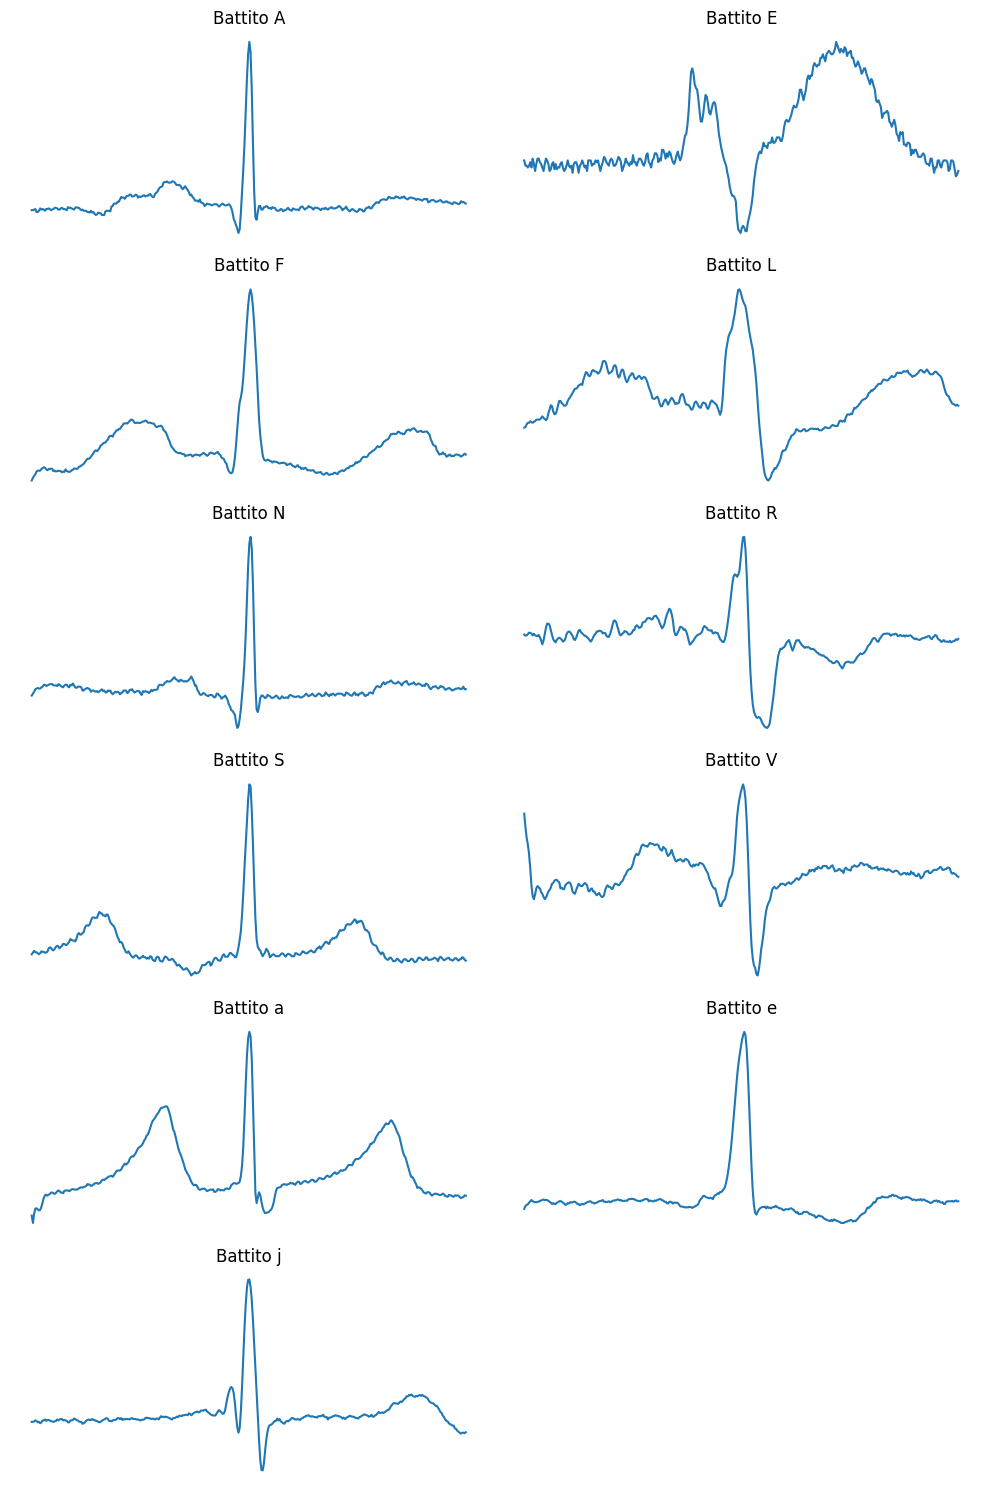

In [23]:
# Plotting one example for each beat type present in the dataset.
print_beats(X, y)

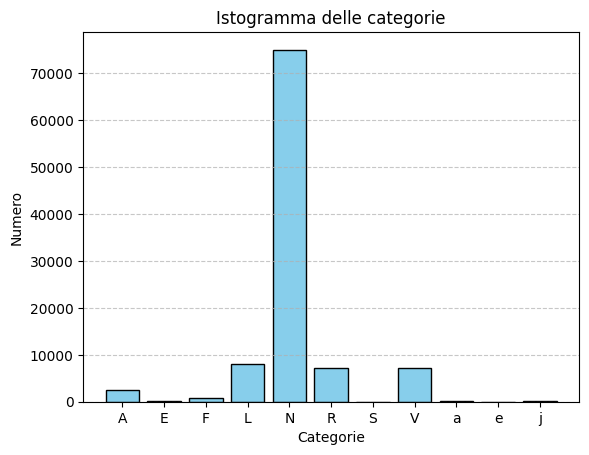

In [24]:
# Plotting data histogram
print_histogram(y)

In [25]:
X.shape

(101317, 360)

# Preprocessing
In this section the dataset will be preprocessed.<br>
We will remove excess elements randomly.<br>
Then we will translate labels to AATM lables.<br>
We will compute the running average of each beat with a window size of 8, smoothing down the ECG.<br>
Finally, we are transforming the target using one hot encoding.

In [26]:
# Removing the excess elements
np.random.seed = 42
random.seed = 42

target_elements = {
    "N":3000,
    "L":2000,
    "R":2000
}
for cat, target in target_elements.items():
    indices_cat = np.where(y == cat)[0]
    indices_to_remove = np.random.choice(indices_cat, size=len(indices_cat) - target, replace=False)
    X = np.delete(X, indices_to_remove, axis=0)
    y = np.delete(y, indices_to_remove, axis=0)


In [27]:
# Computing the running average to smooth the ECG
X = running_average(X, window_size=8)

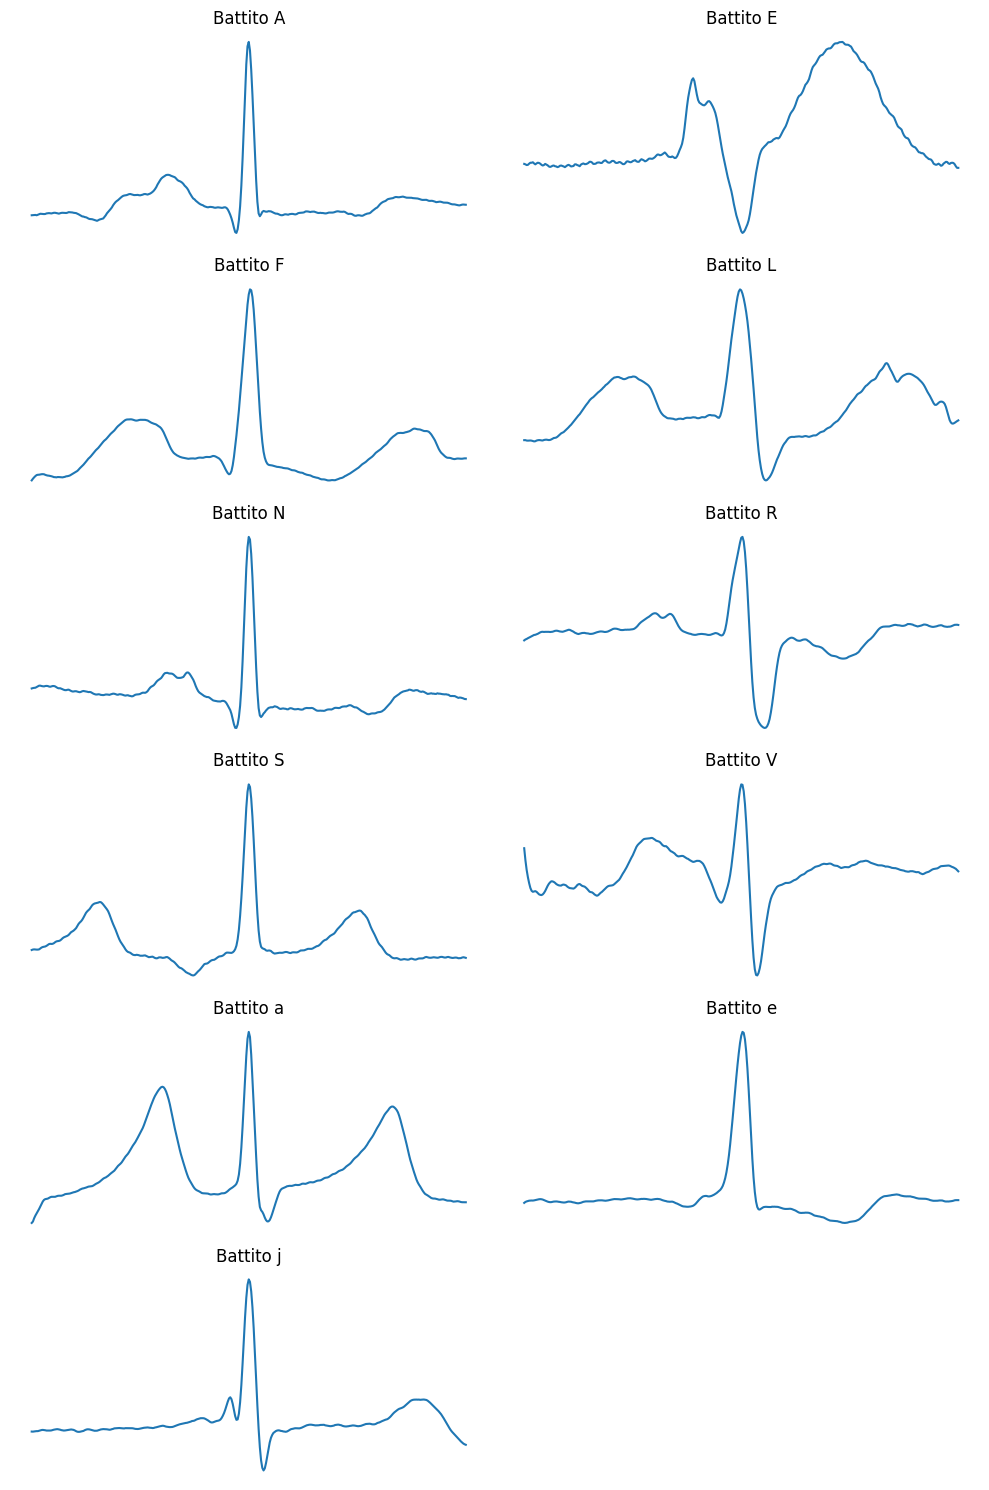

In [28]:
print_beats(X, y)

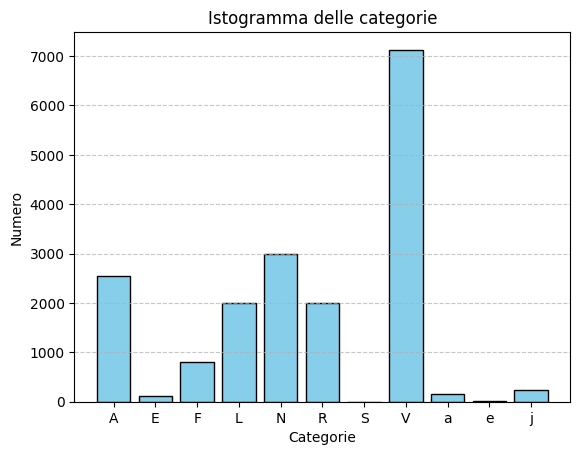

In [8]:
print_histogram(y)

In [9]:
# Translating labels to AATM categories
y[(y=='L')|(y=='R')|(y=='e')|(y=='j')] = 'N'
y[(y=='A')|(y=='a')] = 'S'
y[y=='E'] = 'V'

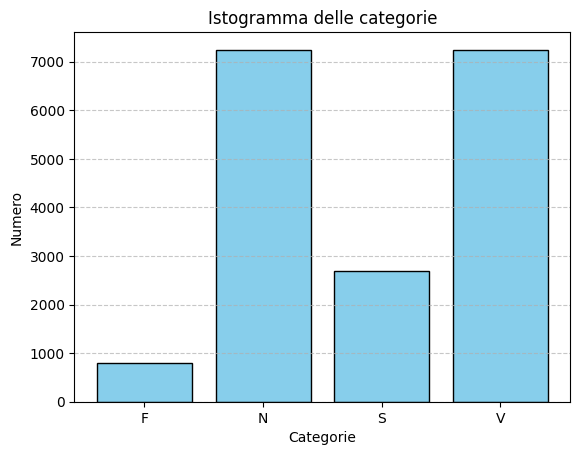

In [10]:
print_histogram(y)

In [ ]:
# One hot encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
one_hot = to_categorical(integer_encoded)

# Training
In this section, we describe the training and evaluation process for the models.<br>
We employ 4-fold cross-validation to reduce the risk of overfitting and ensure more robust performance estimates.<br>
The models are evaluated and compared based on accuracy, balanced accuracy, and per-class recall.

In [ ]:
# Reshape X to match PyTorch CNN1D shape: (N, 1, L)
X = X.reshape(X.shape[0], 1, X.shape[1])

In [ ]:
def training(model, _x, _y, n_epochs = 50, device = "cuda", sample_weight=None, check_gradient = False):
    gradients = []
    # Converting in tensor
    X_train_tensor = torch.tensor(_x, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(_y, dtype=torch.long).to(device)

    # Creating DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    if(sample_weight is not None):
        sample_weight = torch.tensor(sample_weight).to(device)

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            if(sample_weight is not None):
                loss = loss * sample_weight 
                loss = loss.mean()
            loss.backward()

            if check_gradient:
                total_norm = 0
                for p in model.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                total_norm = total_norm ** 0.5
                gradients.append(total_norm)
                
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)

        avg_loss = running_loss / total    
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}")
    
    if check_gradient:
        return gradients

In [ ]:
models_to_test = [
    ECGLSTM,
    ECGRNN,
    ECGGRU,
    ECGCNN,
    ECGHYBRID_LSTM,
    ECGHYBRID_RNN,
    ECGHYBRID_GRU,
    ECGHYBRID_GRU_BN,
    ECGHYBRID_LSTM_BN,
]

EPOCHS = 10
folds = 4
performances = {}

In [ ]:
def test_models(weights=None):
    all_gradients = {}
    for model_class in models_to_test:

        print(f"Training {model_class.name()} model:\n")
        performances[model_class.name()] = {}
        kf = KFold(folds, shuffle=True)

        balanced_accuracy = 0

        count = 0
        gradients = np.array([])
        for train_index, val_index in kf.split(X):
            print(f"Fold {count+1}")
            model = model_class(input_length=X.shape[2], output=len(label_encoder.classes_))

            count += 1
            X_train, X_val = X[train_index, :,:], X[val_index, :,:]
            y_train, y_val = one_hot[train_index], one_hot[val_index]
            y_val_symb = y[train_index]

            if(weights is not None):
                sample_weight = ((y=='F')*weights['F']) + ((y=='N')*weights['N']) + ((y=='S')*weights['S']) + ((y=='V')*weights['V'])
                print("Setting weights")
            else: 
                sample_weight = None

            check_gradient = (model_class is ECGLSTM) or (model_class is ECGRNN)
            new_gradients = training(model, X_train, y_train, n_epochs = EPOCHS, sample_weight=sample_weight, check_gradient=check_gradient)

            if new_gradients:
                if len(gradients)>0:
                    gradients = gradients + np.array(new_gradients)
                else: gradients = np.array(new_gradients)

                
            # Test Dataset and DataLoader
            test_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
            test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

            # Evaluation
            model.eval()
            predictions = []

            with torch.no_grad():
                for X_batch, _ in test_loader:
                    X_batch = X_batch.to("cuda")
                    output = model(X_batch).to("cpu")
                    predictions.append(output)

            # Output concatenation
            test_output = torch.cat(predictions).detach().numpy()

            model.train()

            y_true_labels = np.argmax(y_val, axis=1)
            y_pred_labels = np.argmax(test_output, axis=1)

            balanced_accuracy = 0

            for i, category in enumerate(label_encoder.classes_):
                recall = recall_score(y_true_labels == i, y_pred_labels == i)
                balanced_accuracy += recall
                if category in performances[model_class.name()]:
                    performances[model_class.name()][category] = performances[model_class.name()][category] + recall
                else:
                    performances[model_class.name()][category] = recall

            balanced_accuracy = balanced_accuracy / len(label_encoder.classes_)
            
            if "balanced" in performances[model_class.name()]:
                performances[model_class.name()]["balanced"] = performances[model_class.name()]["balanced"] + balanced_accuracy
            else:
                performances[model_class.name()]["balanced"] = balanced_accuracy

            accuracy = sum(y_true_labels == y_pred_labels) / len(y_true_labels)
            if "accuracy" in performances[model_class.name()]:
                performances[model_class.name()]["accuracy"] = performances[model_class.name()]["accuracy"] + accuracy
            else:
                performances[model_class.name()]["accuracy"] = accuracy

            print("")

        for category in performances[model_class.name()]:
            performances[model_class.name()][category] = performances[model_class.name()][category] / count
        print("")

        if len(gradients)>0:
            gradients = gradients / count
            all_gradients[f"{model_class.__name__}"] = gradients
    return all_gradients


In [ ]:
gradient_dict = test_models()

Training LSTM model:

Fold 1
Epoch 1: Loss=0.2149
Epoch 2: Loss=0.1154
Epoch 3: Loss=0.0897
Epoch 4: Loss=0.0748
Epoch 5: Loss=0.0654
Epoch 6: Loss=0.0567
Epoch 7: Loss=0.0484
Epoch 8: Loss=0.0439
Epoch 9: Loss=0.0418
Epoch 10: Loss=0.0362

Fold 2
Epoch 1: Loss=0.2186
Epoch 2: Loss=0.1139
Epoch 3: Loss=0.0932
Epoch 4: Loss=0.0779
Epoch 5: Loss=0.0656
Epoch 6: Loss=0.0581
Epoch 7: Loss=0.0528
Epoch 8: Loss=0.0474
Epoch 9: Loss=0.0429
Epoch 10: Loss=0.0404

Fold 3
Epoch 1: Loss=0.2113
Epoch 2: Loss=0.1148
Epoch 3: Loss=0.0881
Epoch 4: Loss=0.0738
Epoch 5: Loss=0.0622
Epoch 6: Loss=0.0549
Epoch 7: Loss=0.0483
Epoch 8: Loss=0.0445
Epoch 9: Loss=0.0391
Epoch 10: Loss=0.0340

Fold 4
Epoch 1: Loss=0.2073
Epoch 2: Loss=0.1135
Epoch 3: Loss=0.0883
Epoch 4: Loss=0.0757
Epoch 5: Loss=0.0671
Epoch 6: Loss=0.0575
Epoch 7: Loss=0.0498
Epoch 8: Loss=0.0468
Epoch 9: Loss=0.0404
Epoch 10: Loss=0.0391


Training RNN model:

Fold 1
Epoch 1: Loss=0.2289
Epoch 2: Loss=0.1372
Epoch 3: Loss=0.1163
Epoch 4: L

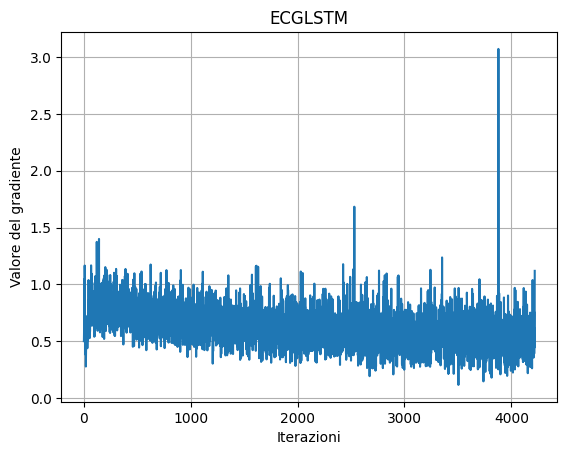

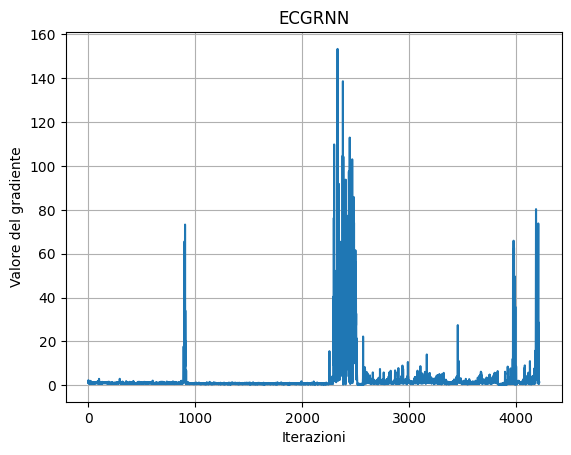

In [ ]:
for metodo, gradients in gradient_dict.items():
    plt.figure() 
    plt.plot(range(len(gradients)), gradients)
    plt.title(metodo)
    plt.xlabel("Iterazioni")
    plt.ylabel("Valore del gradiente")
    plt.grid(True)
    plt.show()

# Results
In this section we show the results

In [ ]:
pd.DataFrame.from_dict(performances, orient='index')

,F,N,S,V,balanced,accuracy
LSTM,0.788619,0.975321,0.918308,0.978189,0.915109,0.959733
RNN,0.197090,0.872981,0.229660,0.489282,0.447253,0.591435
GRU,0.762791,0.979296,0.901600,0.978059,0.905437,0.957453
CNN,0.784807,0.978047,0.916155,0.978424,0.914358,0.960289
HYBRID_LSTM,0.821821,0.980307,0.939863,0.975130,0.929280,0.964961
HYBRID_RNN,0.798721,0.968407,0.910507,0.967746,0.911345,0.952002
HYBRID_GRU,0.842023,0.976145,0.952147,0.980205,0.937630,0.968242
HYBRID_GRU_BN,0.846528,0.984005,0.955920,0.984656,0.942777,0.973804
HYBRID_LSTM_BN,0.872894,0.976263,0.952039,0.985890,0.946771,0.971913
